In [6]:
import os
import numpy as np
import pandas as pd
import csv
from datetime import datetime
from sklearn.metrics import r2_score
import seaborn as sns
import statsmodels.api as sm


from definitions import target_var, country_col, date_col, save_output, fake_num, show_plots, save_figs,fig_size 
from util_general import get_table_path, get_impl_date, get_trans, get_donor_countries
from plot_functions import plot_predictions, plot_diff, plot_cumsum, plot_cumsum_impl, plot_qq
from statistical_tests import shapiro_wilk_test, t_test_result

# custom functions
from definitions import all_paths, country_col, year_col, stat, incl_countries, incl_years, model_val
from util_general import read_data, validate_input, get_trans, get_data_path, get_impl_date
from estimators import arco, sc, did

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from sklearn.linear_model import Lasso
from definitions import fig_size, show_plots, save_figs, treatment_countries
from util_general import get_impl_date, get_fig_path, get_formal_title, get_model_color, get_formal_country_name

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import coint

In [3]:
timeframe = 'm'
model = 'lasso'
fig_size = (10, 6)

In [4]:
df = read_data(source_path=get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}')
df_stat = read_data(source_path=get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}_{stat}')

df = df[(df[country_col].isin(incl_countries)) & (df[year_col].isin(incl_years))]
df_stat = df_stat[(df_stat[country_col].isin(incl_countries)) & (df_stat[year_col].isin(incl_years))]

In [5]:
df_stat

,country,date,year,month,co2,gdp,ind_prod,infl,unempl,pop,brent
0,austria,2001-01-01,2001,1,-0.019138,-0.002088,-0.019,-0.004,-0.027399,-99999.0,-0.001560
1,austria,2001-02-01,2001,2,0.039611,-0.001670,0.018,0.003,0.000000,-99999.0,0.070813
2,austria,2001-03-01,2001,3,0.022160,-0.001253,-0.011,-0.001,0.027399,-99999.0,-0.115513
3,austria,2001-04-01,2001,4,0.119718,-0.000835,-0.015,0.003,0.052644,-99999.0,0.046260
4,austria,2001-05-01,2001,5,0.024326,-0.000423,0.000,-0.003,0.025318,-99999.0,0.098282
...,...,...,...,...,...,...,...,...,...,...,...
4300,united_kingdom,2019-06-01,2019,6,-0.017357,0.004439,-0.005,-0.003,0.000000,-99999.0,-0.104862
4301,united_kingdom,2019-07-01,2019,7,-0.034553,0.006109,-0.002,0.000,0.000000,-99999.0,-0.004682
4302,united_kingdom,2019-08-01,2019,8,-0.020662,0.003989,-0.008,0.004,0.000000,-99999.0,-0.079417
4303,united_kingdom,2019-09-01,2019,9,-0.005156,0.001869,0.004,-0.003,-0.026668,-99999.0,0.062217


In [7]:
for country in df_stat[country_col].unique():
    df_stat_country = df_stat[df_stat[country_col]==country]
    df_stat_country = df_stat_country.set_index(date_col)[get_trans()]
    df_stat_country.index = 

IndentationError: expected an indented block (1962204973.py, line 1)

In [12]:
for country in ['netherlands']:
    df_stat_country = df_stat[df_stat[country_col]==country]
    df_stat_country = df_stat_country.set_index(date_col)[get_trans()]
    df_stat_country.index = pd.to_datetime(df_stat_country.index)
    res = coint(y0=df_stat_country['co2'], y1=df_stat_country['gdp'])
    print(res)

(-4.226265575066112, 0.003327213582908482, array([-3.94577737, -3.36342078, -3.06335351]))


In [11]:
df_stat_country

,co2,gdp,ind_prod,infl,unempl,pop,brent
date,,,,,,,
2001-01-01,0.032427,0.001085,0.030,0.019,-0.030772,0.000583,-0.001560
2001-02-01,0.019071,0.002409,-0.012,-0.005,0.000000,0.000521,0.070813
2001-03-01,0.044768,0.003733,0.013,0.002,0.000000,0.000520,-0.115513
2001-04-01,0.053740,0.005057,0.070,-0.003,-0.031749,0.000520,0.046260
2001-05-01,0.026855,0.003950,-0.022,-0.005,0.000000,0.000665,0.098282
...,...,...,...,...,...,...,...
2019-06-01,-0.024403,0.003978,-0.012,0.002,0.022990,0.000769,-0.104862
2019-07-01,0.005596,0.003886,0.001,0.010,0.000000,0.000768,-0.004682
2019-08-01,-0.044534,0.003894,0.003,-0.003,0.022473,0.000749,-0.079417


<AxesSubplot:xlabel='date'>

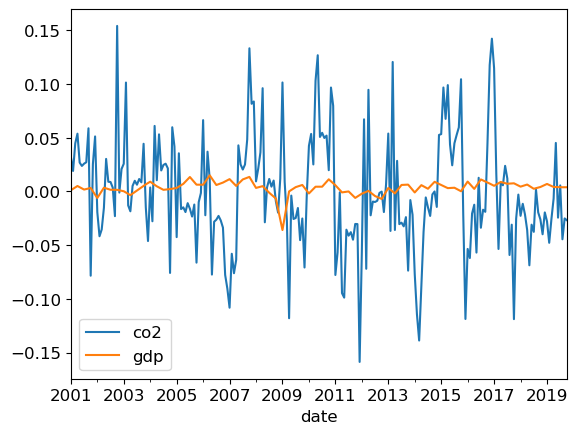

In [13]:
df_stat_country[['co2', 'gdp']].plot()

# Johansen test

In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
jres = coint_johansen(df_stat_country, det_order=0, k_ar_diff=1)

In [23]:
# trace test
print(jres.trace_stat)
print(jres.trace_stat_crit_vals)

[574.37824783 396.52222331 240.79006587 142.70246719  79.81032474
  37.73093864  15.46349184]
[[120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [22]:
# eigenvalue test
print(jres.max_eig_stat)
print(jres.max_eig_stat_crit_vals)

[177.85602452 155.73215744  98.08759868  62.89214246  42.0793861
  22.2674468   15.46349184]
[[43.2947 46.2299 52.3069]
 [37.2786 40.0763 45.8662]
 [31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
